# Question 2

A  colleague is interested in the open cluster Ruprecht 147 (RA = 289.074 deg, Dec =
-16.323 deg) and is considering an observation proposal using the 2dF fibre positioner and
HERMES spectrograph (effective for Gaia G band magnitudes < 14). They need to know
if there are enough bright stars in this region for observation, and how bright these stars
would be in the wavelength region of the APOGEE spectrograph (which operates in the
H-band). Your task is to assist by querying data from Gaia DR3 and performing some
basic analysis


In [1]:
import os

# Make sure the "data" folder exists
if not os.path.exists('data'):
    os.makedirs('data')
# Make sure the "figure" folder exists
if not os.path.exists('figure'):
    os.makedirs('figure')

1) Download all stars within 1 degree of the center of Ruprecht 147 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the """query""" notation)


In [2]:
from astroquery.gaia import Gaia
from astropy.table import Table

# ADQL query to get Gaia DR3 sources near Ruprecht 147
query = """
SELECT *
FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', 289.074, -16.323, 1.0)
      )
  AND phot_g_mean_mag < 14
"""

# Launch the ADQL query
job_gaia = Gaia.launch_job_async(query=query)

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
# Get the results as an Astropy Table
rup147_gaia = job_gaia.get_results()
rup147_gaia.write('data/rup147_gaia.csv', format='csv', overwrite=True)

# ADQL query to join Gaia DR3 with 2MASS catalog
query = """
SELECT gaia.source_id, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.parallax,
       tmass.h_m, tmass.j_m, tmass.ks_m, tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass 
     ON xjoin.original_psc_source_id = tmass.designation
WHERE
  1=CONTAINS(
      POINT('ICRS', gaia.ra, gaia.dec),
      CIRCLE('ICRS', 289.074, -16.323, 1.)
  )
  AND gaia.phot_g_mean_mag < 14
"""

job = Gaia.launch_job_async(query=query)
ex_rup147 = job.get_results()
df_rup147 = ex_rup147.to_pandas()
df_rup147.to_csv('data/rup147_join.csv', index=False, header=True)

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
len(df_rup147)

3637

In [5]:
# # Extract only the Gaia DR3 source IDs for crossmatching
gaia_data = Table.read('data/rup147_gaia.csv')
gaia_source_ids = gaia_data['source_id'].tolist()

# # Convert the source IDs to an Astropy table to use in the query (to not upload too much data)
# # with the actual identifier in Gaia DR3 (source_id)
ids_table = Table([gaia_source_ids], names=['source_id'])
ids_table.write('data/gaia_source_ids_table.csv', format='csv', overwrite=True)

In [6]:
len(ids_table) 

3663

In [7]:
len(df_rup147) 

3637

2. Determine how many stars are returned from the initial query.



In [8]:
# Read the Gaia data to get the number of stars)
num_stars_gaia = len(ids_table)
print(f"Number of stars in initial Gaia query: {num_stars_gaia}")

Number of stars in initial Gaia query: 3663


3. Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’

In [9]:
#Stars with bad 2MASS photometry
bad_2mass = df_rup147[df_rup147['ph_qual'] != 'AAA']
print(f"Number of stars with bad 2MASS photometry: {len(bad_2mass)}")

Number of stars with bad 2MASS photometry: 79


4. Identify any stars with negative (or non-positive) parallaxes in the Gaia data

In [10]:
# Stars with non-positive parallaxes
bad_parallax = df_rup147[df_rup147['parallax'] <= 0]
print(f"Number of stars with non-positive parallax: {len(bad_parallax)}")

Number of stars with non-positive parallax: 5


5. Apply these two quality cuts (removing stars with bad 2MASS photometry and non-
positive parallaxes). After applying the cuts, determine how many stars remain.

In [11]:
# Apply quality cut
good_stars = df_rup147[(df_rup147['parallax'] > 0) & (df_rup147['ph_qual'] == 'AAA')]
num_good_stars = len(good_stars)
print(f"Number of stars after quality cuts: {num_good_stars}")

# Diagnostics to explain why more rows are removed
total_removed = len(df_rup147) - num_good_stars
print(f"Total removed: {total_removed}")

# Count how many were removed due to bad 2MASS quality
bad_2mass = df_rup147[df_rup147['ph_qual'] != 'AAA']
print(f"Removed due to bad 2MASS quality: {len(bad_2mass)}")

# Count how many were removed due to non-positive parallaxes
bad_parallax = df_rup147[df_rup147['parallax'] <= 0]
print(f"Removed due to non-positive parallax: {len(bad_parallax)}")

# Count how many were removed due to missing parallaxes (NaN)
missing_parallax = df_rup147['parallax'].isna().sum()
print(f"Removed due to missing parallax values: {missing_parallax}")


Number of stars after quality cuts: 3535
Total removed: 102
Removed due to bad 2MASS quality: 79
Removed due to non-positive parallax: 5
Removed due to missing parallax values: 18


6. Using the remaining stars, generate a figure with two panels (1 point per panel):

    – (a) A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magni-
tude.

    – (b) A 2MASS J-Ks vs. apparent H magnitude diagram

7. Save the figure as figures/cmds R147.png with a resolution of 200 dots per inch


/tmp/ipykernel_6614/2217728654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_stars['abs_G'] = good_stars['phot_g_mean_mag'] - 5 * np.log10(1000 / good_stars['parallax']) + 5
/tmp/ipykernel_6614/2217728654.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_stars['J_minus_Ks'] = good_stars['j_m'] - good_stars['ks_m']


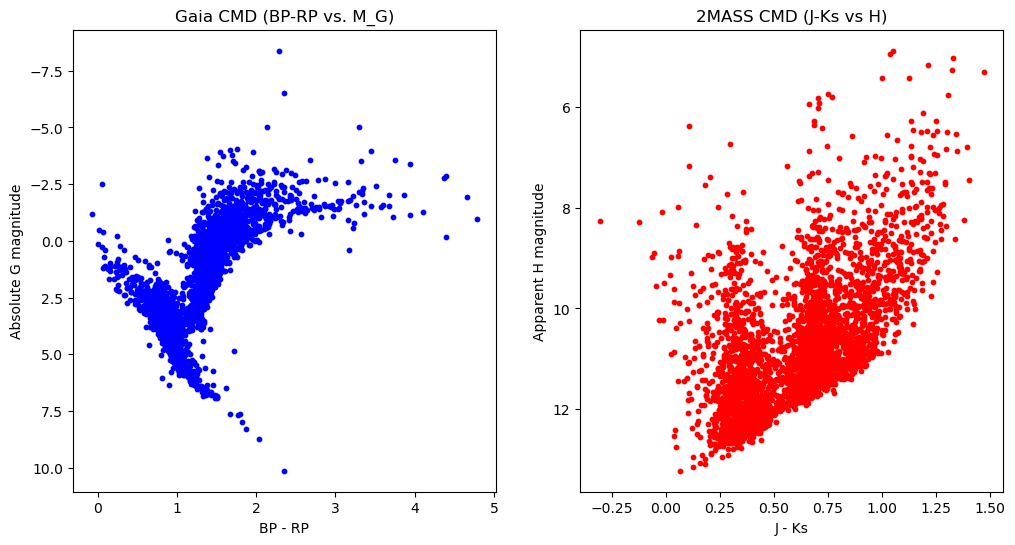

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate absolute G magnitude
good_stars['abs_G'] = good_stars['phot_g_mean_mag'] - 5 * np.log10(1000 / good_stars['parallax']) + 5

# Calculate J-Ks color
good_stars['J_minus_Ks'] = good_stars['j_m'] - good_stars['ks_m']

# Make figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Panel (a): Gaia CMD
ax1.scatter(good_stars['bp_rp'], good_stars['abs_G'], s=10, color='blue')
ax1.set_xlabel('BP - RP')
ax1.set_ylabel('Absolute G magnitude')
ax1.invert_yaxis()
ax1.set_title('Gaia CMD (BP-RP vs. M_G)')

# Panel (b): 2MASS H vs J-Ks
ax2.scatter(good_stars['J_minus_Ks'], good_stars['h_m'], s=10, color='red')
ax2.set_xlabel('J - Ks')
ax2.set_ylabel('Apparent H magnitude')
ax2.invert_yaxis()
ax2.set_title('2MASS CMD (J-Ks vs H)')

# Save figure
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/cmds_R147.png', dpi=200)
plt.show()

Using Gaia DR3 data and crossmatching with the 2MASS catalog, we selected stars within 1 degree of the center of Ruprecht 147 (RA = 289.074 deg, Dec = -16.323 deg) with Gaia G-band magnitude brighter than 14. After applying quality cuts to remove stars with bad 2MASS photometry (ph_qual ≠ 'AAA') and non-positive or missing parallaxes, a total of 3535 stars remain suitable for observation.

The 2dF fibre positioner facility on the Anglo-Australian Telescope has 392 fibres available per field of view. Given that the number of qualified stars greatly exceeds this limit, observing all targets in a single field is not possible. The proposal should allocate fibres to the top-priority targets (up to 392 fibres per field) and plan multiple pointings or a target selection strategy to cover the full sample.

### Recommendation

Assign fibres to the brightest, highest quality stars from the vetted sample during each 2dF field pointing, utilizing the maximum 392 fibres available. Multiple field configurations will be required to observe the entire star sample of Ruprecht 147.

This strategy ensures optimized use of the 2dF-HERMES instrument, maximizing scientific return within operational constraints.